In [1]:
# 먼저 데이터가 저장된 폴더를 연결합시다.
!mkdir -p aiffel/time_series_basic
#!ln -s data/* aiffel/time_series_basic
!cp data/AirPassengers.csv aiffel/time_series_basic/

cp: cannot stat 'data/AirPassengers.csv': No such file or directory


In [2]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.0/908.0 KB 13.4 MB/s eta 0:00:00a 0:00:01


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #acf plot 및 pacf plot을 그리기 위한 라이브러리
from statsmodels.tsa.arima_model import ARIMA #아리마 모델
import pmdarima as pm #오토 아리마

In [ ]:
# 라이브러리 버전 충돌을 피하기 위해 런타임을 재시작합니다.
import os
os.kill(os.getpid(), 9)

In [4]:
ap = pd.read_csv('/aiffel/aiffel/time_series_basic/AirPassengers.csv')
ap.drop('Month', axis = 1, inplace = True)

In [5]:
ap

,#Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


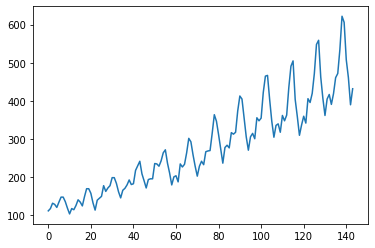

In [6]:
plt.plot(ap)
plt.show()

In [7]:
ap_transformed =np.log(ap)

In [8]:
ap_transformed

,#Passengers
0,4.718499
1,4.770685
2,4.882802
3,4.859812
4,4.795791
...,...
139,6.406880
140,6.230481
141,6.133398
142,5.966147


[]

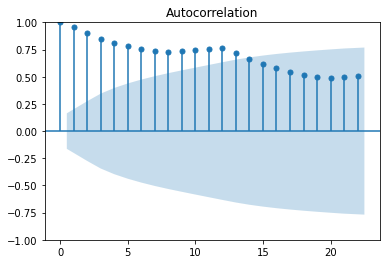

In [9]:
plot_acf(ap_transformed) #acf plot, 점차 감소하는 모양새를 지니고 있음
plt.plot()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


[]

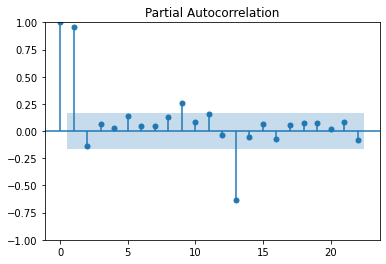

In [10]:
plot_pacf(ap_transformed) #pacf plot, lag 2까지 유의미한 결과를 보임
plt.plot()

In [11]:
ap_diff = ap_transformed.diff()
ap_diff = ap_diff.dropna()

[]

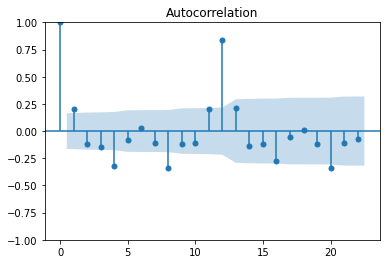

In [12]:
# lag 1과 lag 12에서 유의미한 lag가 포착됨
plot_acf(ap_diff)#[[YOUR CODE]])
plt.plot()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


[]

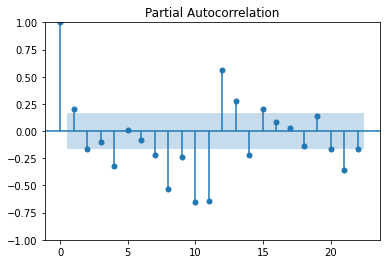

In [13]:
plot_pacf(ap_diff)
plt.plot()

In [14]:
ap_transformed

,#Passengers
0,4.718499
1,4.770685
2,4.882802
3,4.859812
4,4.795791
...,...
139,6.406880
140,6.230481
141,6.133398
142,5.966147


In [15]:
train_size = int(len(ap_transformed)*0.8)

ap_transformed_train = ap_transformed[:train_size]
ap_transformed_test =ap_transformed[train_size:]

In [16]:
model = pm.AutoARIMA(seasonal = True, suppress_warnings = True, trace = True, max_D = 12) #seasonal = True 체크, # 계절차분(D) = 12
res = model.fit(ap_transformed_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-189.733, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-191.035, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-192.641, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-189.957, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-196.702, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-196.895, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-196.569, Time=0.11 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 4.298 seconds


In [17]:
#confidence interval까지 도출
preds, conf_int = res.predict(n_periods=ap_transformed_test.shape[0], return_conf_int=True) 

# 아래의 코드 결과값을 서로 비교 분석해봅시다.
print(preds.shape) 
print(type(preds))
print('--'*40)
print(preds.shape[0])
print(type(preds.shape[0]))
# print('--'*40)
# print(preds)
# print('--'*40)
# print(conf_int)

(29,)
<class 'numpy.ndarray'>
--------------------------------------------------------------------------------
29
<class 'int'>


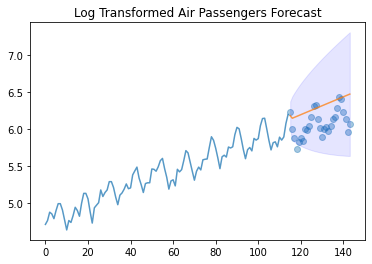

In [18]:
# 예측 성능을 시각화합니다. 
# 0. train과 test data를 축(axis)으로 만들었습니다.
# 1. x축은 test으로 만들어 놓은 train data를 사용하고, y축에 train data를 사용하여 train data를 시각화 합니다.
# 2. 1번 그래프에서 정답(AutoARIMA를 통해 만든 예측 값)에 해당하는 일자형 그래프가 생성됩니다.
# 3. 원래 가지고 있던 데이터셋의 y값(지도 학습의 정답)을 산점도(scatter plot)로 생성합니다.
# 4. 2, 3번의 분포에 해당하는 구간을 채워 그래프로 나타냈습니다.
x_axis = np.arange(ap_transformed_train.shape[0] + preds.shape[0]) # 115 + 29, plot을 그리기 위해 x축을 생성합니다. # 0
plt.plot(x_axis[:ap_transformed_train.shape[0]],ap_transformed_train, alpha=0.75) # 1
plt.plot(x_axis[ap_transformed_train.shape[0]:], preds, alpha=0.75) # 2
plt.scatter(x_axis[ap_transformed_train.shape[0]:],ap_transformed_test, 
            alpha=0.4, marker='o')  # 3 기존 test data는 scatter
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b') # 4
plt.title("Log Transformed Air Passengers Forecast") # plot의 제목
plt.show() # 4개의 plot을 시각화 합니다.

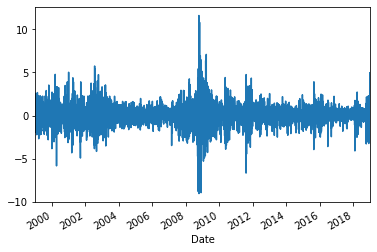

In [19]:
# ⑦-1 : 데이터 및 라이브러리 불러오기
import datetime as dt # 날짜와 시간을 조작할 수 있는 Python 라이브러리 입니다.
import arch.data.sp500 # S&P 500 데이터셋을 arch에서 불러옵니다.

# ⑦-2 : 필요한 데이터로 가공하고 시각화를 통해 확인하기
st = dt.datetime(2002, 1, 1) #start date
en = dt.datetime(2022, 1, 1) #end date
data = arch.data.sp500.load() #s&p 500 데이터 불러오기
market = data["Adj Close"] #종가만 활용
returns = 100 * market.pct_change().dropna() #return값으로 변환
ax = returns.plot() # 수익률을 그래프로 만들기
xlim = ax.set_xlim(returns.index.min(), returns.index.max()) # xlim은 x축 값의 보기를 제한 합니다. 
plt.show()

# ⑦-3 : ARCH 모델 적용
from arch import arch_model

am = arch_model(returns) #return을 arch모델에 적합
res = am.fit(update_freq=5)

# ⑦-4 : 지표를 통한 결과 확인
print(res.summary())
#다양한 결과가 제시되어있으나, 수업때 배웠던 p-value, AIC, BIC위주로 내용을 파악
#아래에 있는 volatility model을 보면 alpha[1], Beta[1]은 GARCH(1,1)을 의미하며, p-value를 통해 신뢰도 99%에서 이들이 유의미함을 도출

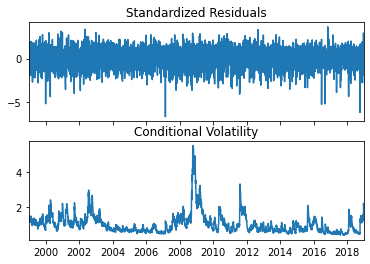

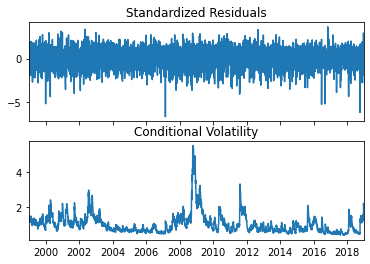

In [21]:
# ⑦-5 : 시각화를 통한 결과값 확인
res.plot()

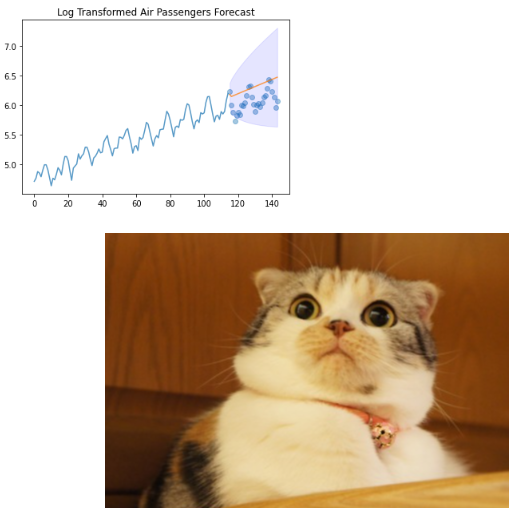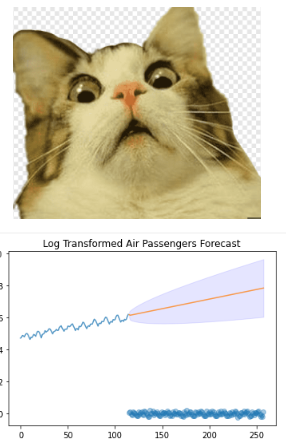
왜 달라 서로 똑같은코드에 실행순서또한 똑같은데..
# 회고 
오류 너무싫고 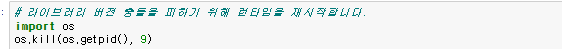이코드는 어쩔때 써야하는질 모르겠으
라이브러리 불러오고나서 실행시키니까 전부다 오류가나냐.....한차례 식겁했고..........
쥬피터 한번에 2개를켜놓으면 서로 커넥팅걸다가 터지는걸 또 배웠으며....
복붙해서 터지면 어디서 뭐가 뭔 문제인질  모르겠으여...아따 코딩 어렵네잉
행복한 구정보내시고....이상 혼잣말이였습니다.

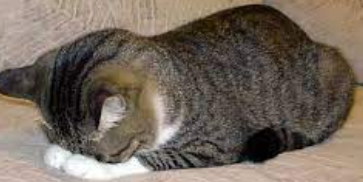